# Customer Survival Analysis For "Global Credit" UCO

## TOC:
* [Getting the data from DB](#Getting-Data-From-the-Database)
* [Feature Description](#Feature-Meaning)
* [Explortory Data Analysis](#EDA)
* [Data Preperation for Modelling](#Preparing-the-Data-for-Modelling)
* [Kaplan-Meier Estimator](#Kaplan-Meier)
* [Accelerated-Failure Time (AFT)](#Accelerated-Failure-Time-(AFT))

In [1]:
from modelling.survival_analysis import Survival
from modelling.database import engine
from modelling.utils import from_sql_to_pandas

from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

## Getting Data From the Database

**Note:** The survival data generation process is conducted using the `update_survival_data()` procedure in the database. You can find the procedure in the `survival_pipeline/db_setup/sql_queries` folder.

In [2]:
data = from_sql_to_pandas(engine, "survival_data")
data.head()

,cliid,app_id,ap_date,close_date,contractperiod,paidamount,initialamount,exp_int,riskclass,serveddays,...,n_salary,n_vehicles,n_dahk,n_dependents,been_married,sum_dahk,mobile_operator,marz,tenure,event
0,47,436912,2021-06-08 15:39:00,2022-10-14,28,143898.81,80000.0,72.0,Հսկվող,492,...,107000.0,0,0,0,0,0.0,VivacellMTS,ԵՐԵՎԱՆ,8,True
1,156,915224,2021-12-13 14:45:00,2022-02-11,3,106515.25,100000.0,48.0,Ստանդարտ,59,...,86430.0,0,0,0,0,0.0,Beeline,ԿՈՏԱՅՔ,2,True
2,315,641049,2021-09-09 14:02:00,2022-06-14,16,252460.38,200000.0,45.0,Ստանդարտ,277,...,0.0,0,9,0,1,63000.0,Ucom,ԵՐԵՎԱՆ,6,True
3,342,966406,2021-12-30 11:12:00,2022-02-07,16,106637.53,100000.0,72.0,Ստանդարտ,38,...,138053.0,1,7,3,1,95000.0,VivacellMTS,ԳԵՂԱՐՔՈՒՆԻՔ,1,True
4,379,814556,2021-11-11 05:20:00,2022-07-31,34,291203.31,200000.0,72.0,Հսկվող,261,...,426165.0,0,10,3,1,71500.0,Beeline,ԵՐԵՎԱՆ,605,False


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4694 entries, 0 to 4693
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cliid            4694 non-null   int64         
 1   app_id           4694 non-null   int64         
 2   ap_date          4694 non-null   datetime64[ns]
 3   close_date       4694 non-null   datetime64[ns]
 4   contractperiod   4694 non-null   int64         
 5   paidamount       4694 non-null   float64       
 6   initialamount    4694 non-null   float64       
 7   exp_int          4694 non-null   float64       
 8   riskclass        4694 non-null   object        
 9   serveddays       4694 non-null   int64         
 10  ficoscore        4694 non-null   int64         
 11  npaidcount       4694 non-null   int64         
 12  naplcount        4694 non-null   int64         
 13  n_dpds           4694 non-null   int64         
 14  max_dpd          4694 non-null   int64  

# Feature Meaning

- `cliid`: Client ID, a unique identifier for each client.
- `app_id`: Application ID, a unique identifier for each loan application.
- `ap_date`: Application date, the date when the loan application was made.
- `close_date`: Closing date, the date when the loan contract was closed.
- `contractperiod`: Contract period, the duration of the loan contract in months.
- `paidamount`: Amount paid, the total amount paid by the client (with interest).
- `initialamount`: Initial amount, the initial amount of the contract.
- `exp_int`: Expected Interest, the interest rate.
- `riskclass`: Risk class, the risk category associated with the client.
- `serveddays`: Served days, the number of days the contract has been active.
- `ficoscore`: FICO score, a measure of credit risk.
- `npaidcount`: Number of past paid loans.
- `naplcount`: Number of past loan applications.
- `n_dpds`: Number of times the client paid the past due date.
- `max_dpd`: Maximum days past due.
- `age`: Age of the client.
- `gender`: Gender of the client.
- `n_salary`: Net salary of the client (AMD).
- `n_vehicles`: Number of vehicles owned by the client.
- `n_dahk`: Number of enforcement proceedings of the client.
- `sum_dahk`: Amount (AMD) of enforcement proceedings of the client.
- `n_dependents`: Number of dependents.
- `been_married`: Marital status (0: Never been married, 1: Has been married).
- `mobile_operator`: Mobile operator used by the client.
- `marz`: Region of the client.
- `tenure`: Tenure, the duration between the client closing his/her latest loan (in 2021) and taking the next.
- `event`: Event, a boolean indicating if an event occurred (i.e. True if took another loan).


In [4]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
cliid,4694.0,560911.138049,47.0,538071.75,584525.0,646695.0,680082.0,148859.228245
app_id,4694.0,621365.942267,215496.0,406987.75,643939.5,838828.75,970966.0,234204.92786
ap_date,4694,2021-08-13 06:05:44.098849792,2021-01-01 11:02:00,2021-05-17 06:34:30,2021-09-10 14:14:30,2021-11-19 05:01:15,2021-12-31 22:40:00,NaN
close_date,4694,2022-05-31 00:18:05.982104832,2021-01-31 00:00:00,2021-12-16 00:00:00,2022-03-23 00:00:00,2022-11-07 18:00:00,2024-03-16 00:00:00,NaN
contractperiod,4694.0,23.431402,0.0,16.0,28.0,33.0,36.0,10.722518
paidamount,4694.0,213500.679708,0.0,120651.6225,174854.92,268875.4375,1292771.0,132062.14175
initialamount,4694.0,163641.60033,50000.0,100000.0,150000.0,200000.0,650000.0,92689.467592
exp_int,4694.0,60.97124,25.0,47.0,57.0,72.0,110.0,18.268187
serveddays,4694.0,290.269493,0.0,72.0,209.0,442.0,1123.0,264.66175
ficoscore,4694.0,566.701321,0.0,537.0,565.0,593.0,765.0,41.838134


A few interesting findings from the above table:
* We have a total of **4690** clients to analyze.
* The average loan size (initial amount) is around **160000 AMD**, and the average serving time (served days) is **290 days**.
  
Let's also explore average tenure (days between closing a CashMe loan and taking the next) based on event.  

In [5]:
average_tenure_by_event = data.groupby('event')['tenure'].mean()
print(average_tenure_by_event)

event
False    627.709192
True     123.910820
Name: tenure, dtype: float64


* As can be seen, it usually takes 123 days for returning customers to activate their next loan. 

# EDA

* ### Distribution of Numerical Features

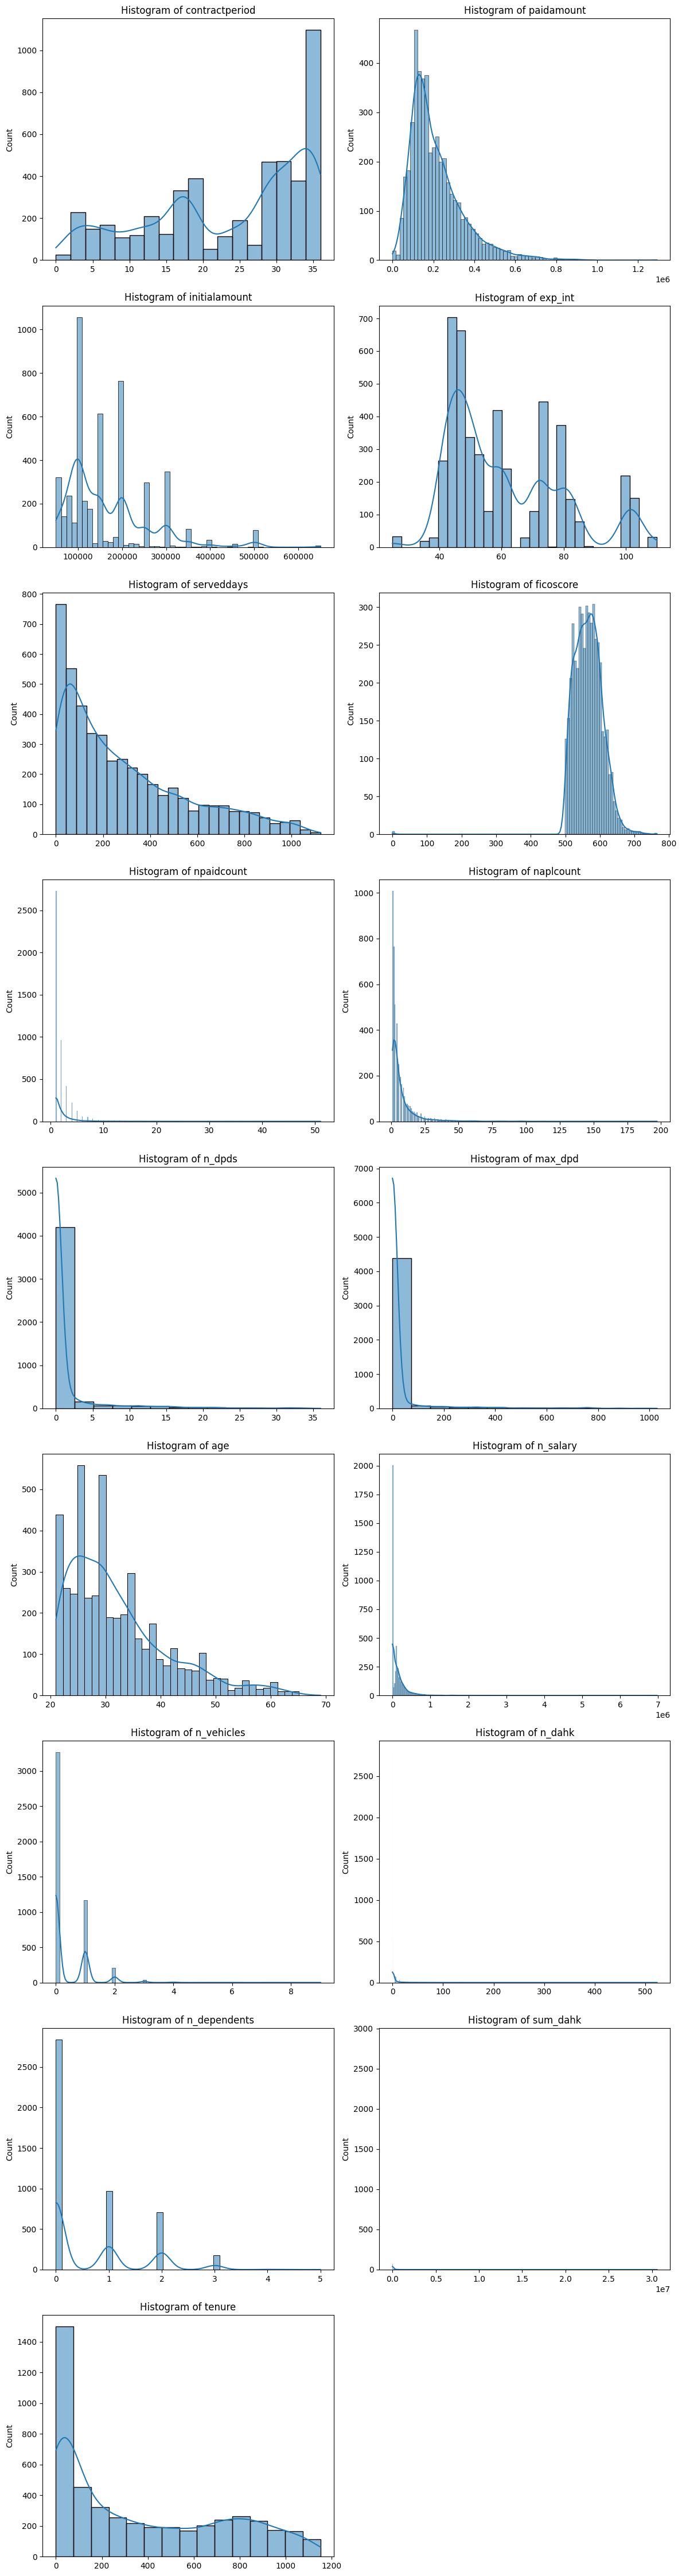

In [6]:
# Determine numeric features by excluding object-type columns
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [i for i in numeric_features if i not in ("cliid", "app_id", "been_married")]

# Determine the layout of subplots dynamically based on the number of numeric features
num_features = len(numeric_features)
num_cols = min(2, num_features)
num_rows = (num_features - 1) // num_cols + 1

# Plot histograms for each numeric feature
plt.figure(figsize=(6 * num_cols, 5 * num_rows))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(data, x=feature, kde=True)
    plt.title(f"Histogram of {feature}")
    plt.xlabel("") 

plt.tight_layout()
plt.show()

From the above, we can see a few concerns:
* The distributions of `n_dahk` and `sum_dahk` are heavily skewed, with the great majority of clients having a 0 value for these variables. This can be explained by the fact that most clients probably do not have any legal proceedings against them; thus, for modeling, let's introduce a binary variable called `has_dahk` that will simply record whether the individual has had legal proceedings against them or not.
* The same can be seen for the variable `n_salary`. It's important to note that 0's in the data reflect that the person does not have officially registered income. The absence of registered income could also serve as a significant indicator

In [7]:
data['has_dahk'] = data['n_dahk'].apply(lambda x: 0 if x == 0 else 1)

* ### Distribution of Categorical Features

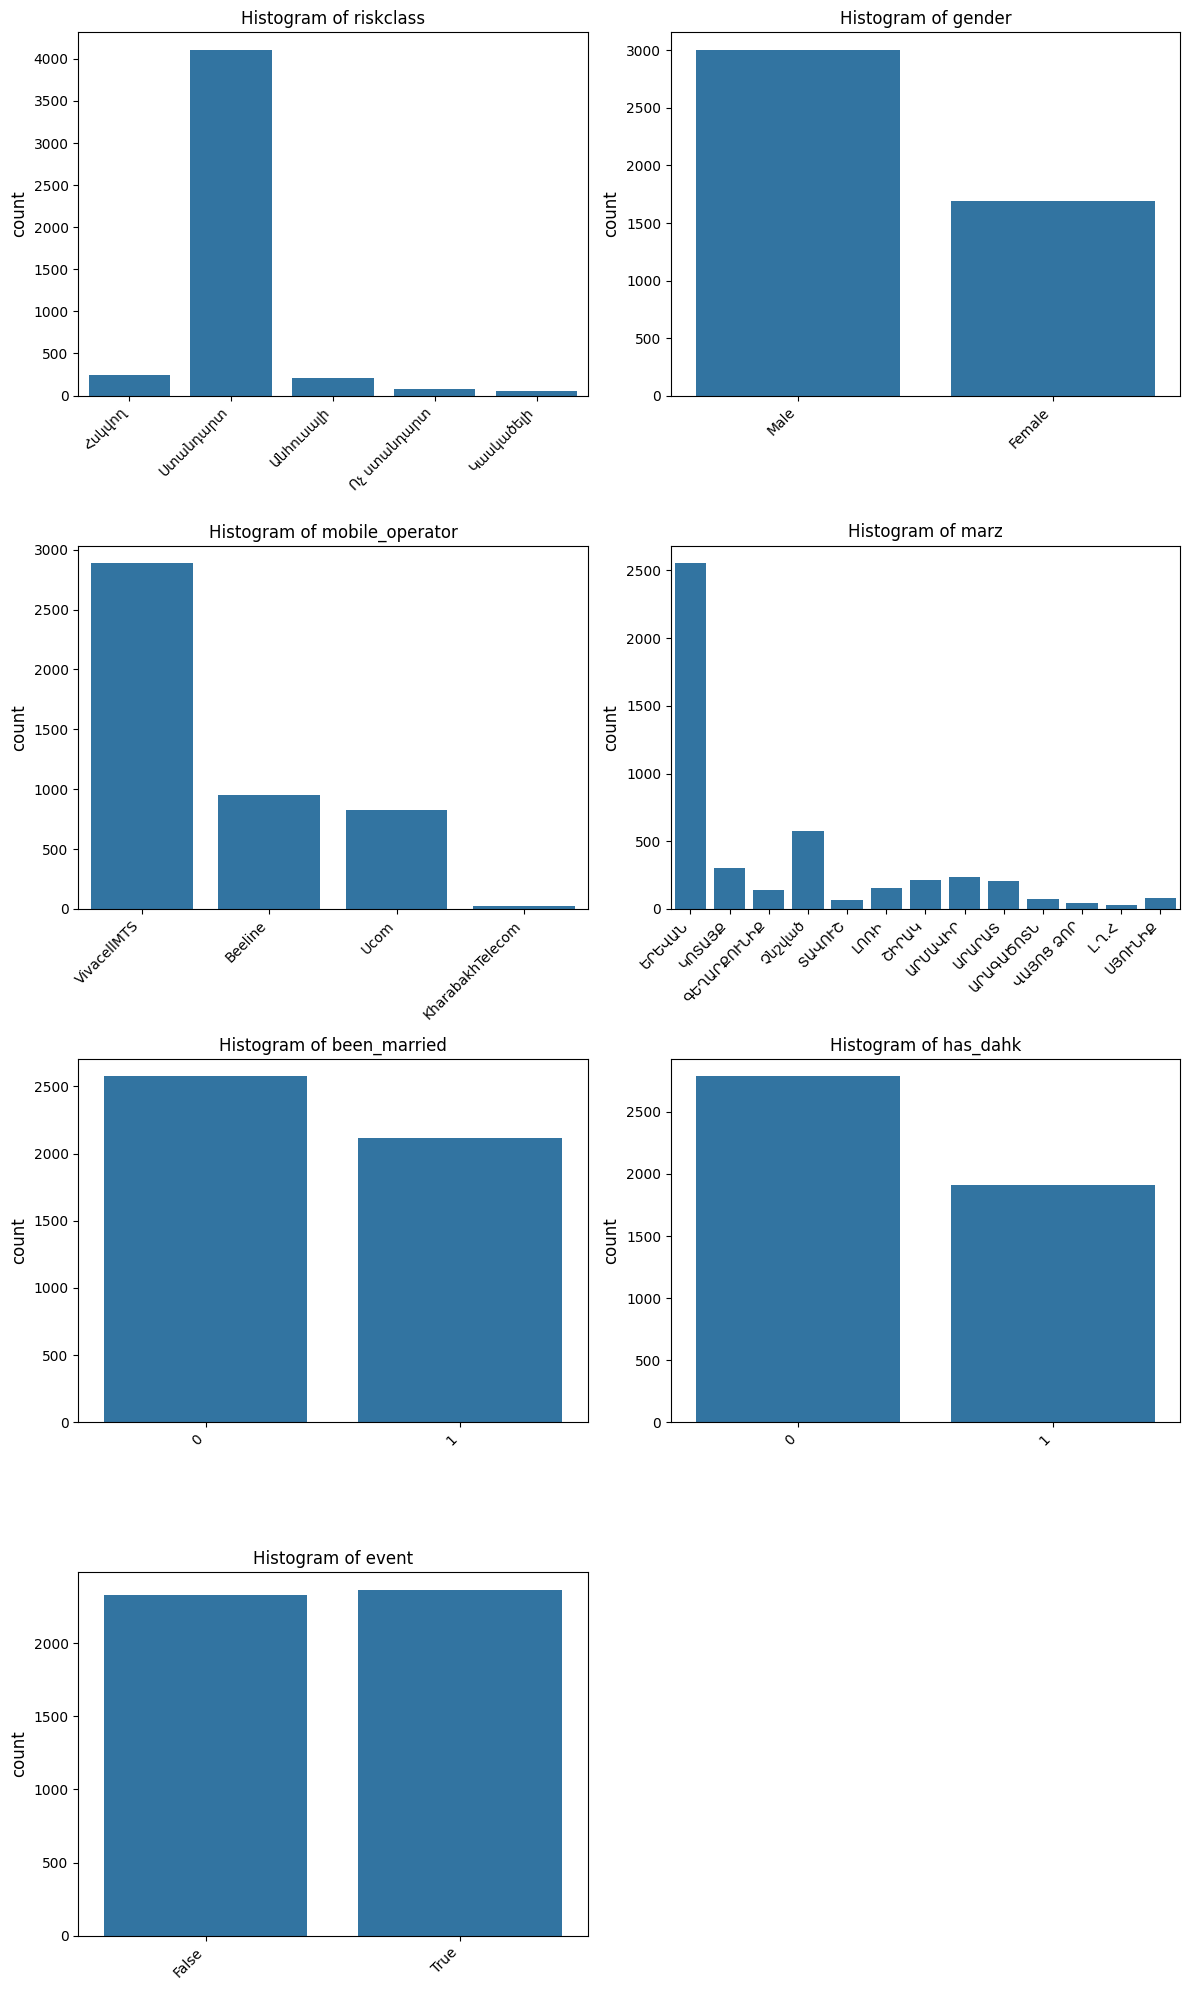

In [8]:
# Define categorical features
categorical_features = ["riskclass", "gender", "mobile_operator", "marz", 'been_married',\
                        'has_dahk','event']

# Determine the layout of subplots dynamically based on the number of categorical features
num_features = len(categorical_features)
num_cols = min(2, num_features)
num_rows = (num_features - 1) // num_cols + 1

# Plot bar charts for each categorical feature
plt.figure(figsize=(6 * num_cols, 5 * num_rows))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(data, x=feature)
    plt.title(f"Histogram of {feature}")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("")
    plt.ylabel('count', fontsize = 12)


plt.tight_layout()
plt.show()

We can see that the distribution of the variable `has_dahk` is much more balanced. 

# Preparing the Data for Modelling

In [9]:
# dummifying categorical variables
encode_cols = ["riskclass", "gender", "mobile_operator", "marz"]

survival_df = pd.get_dummies(
    data, columns=encode_cols, prefix=encode_cols
)

# Specify which dummy columns to drop - reference categories, as well as columns not meaningful for analysis
columns_to_drop = ["riskclass_Ստանդարտ", "gender_Female", "mobile_operator_Ucom",\
                   "marz_ԵՐԵՎԱՆ","app_id", "ap_date", "close_date", "sum_dahk", "n_dahk"]

#exclude the columns not needed for modeling
survival_df = survival_df.drop(columns=columns_to_drop)

In [10]:
#remaining features
survival_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4694 entries, 0 to 4693
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cliid                             4694 non-null   int64  
 1   contractperiod                    4694 non-null   int64  
 2   paidamount                        4694 non-null   float64
 3   initialamount                     4694 non-null   float64
 4   exp_int                           4694 non-null   float64
 5   serveddays                        4694 non-null   int64  
 6   ficoscore                         4694 non-null   int64  
 7   npaidcount                        4694 non-null   int64  
 8   naplcount                         4694 non-null   int64  
 9   n_dpds                            4694 non-null   int64  
 10  max_dpd                           4694 non-null   int64  
 11  age                               4694 non-null   int64  
 12  n_sala

* ### Exploring Correlations

In [11]:
# Calculate correlation matrix
corr_matrix = survival_df.corr()

# Set correlation threshold
threshold = 0.8

# Iterate through the correlation matrix and extract pairs of features with correlation coefficients above the threshold
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            correlation = corr_matrix.iloc[i, j]
            high_corr_pairs.append((feature1, feature2, correlation))

# Print high correlation pairs
print("Highly correlated pairs with correlation coefficient above", threshold)
for pair in high_corr_pairs:
    print(pair[0], "-", pair[1], "- Correlation:", pair[2])


Highly correlated pairs with correlation coefficient above 0.8
paidamount - initialamount - Correlation: 0.9025455979611472
n_dpds - max_dpd - Correlation: 0.92737419413956


**Let's also plot correlation heatmap to get a visual representation.**

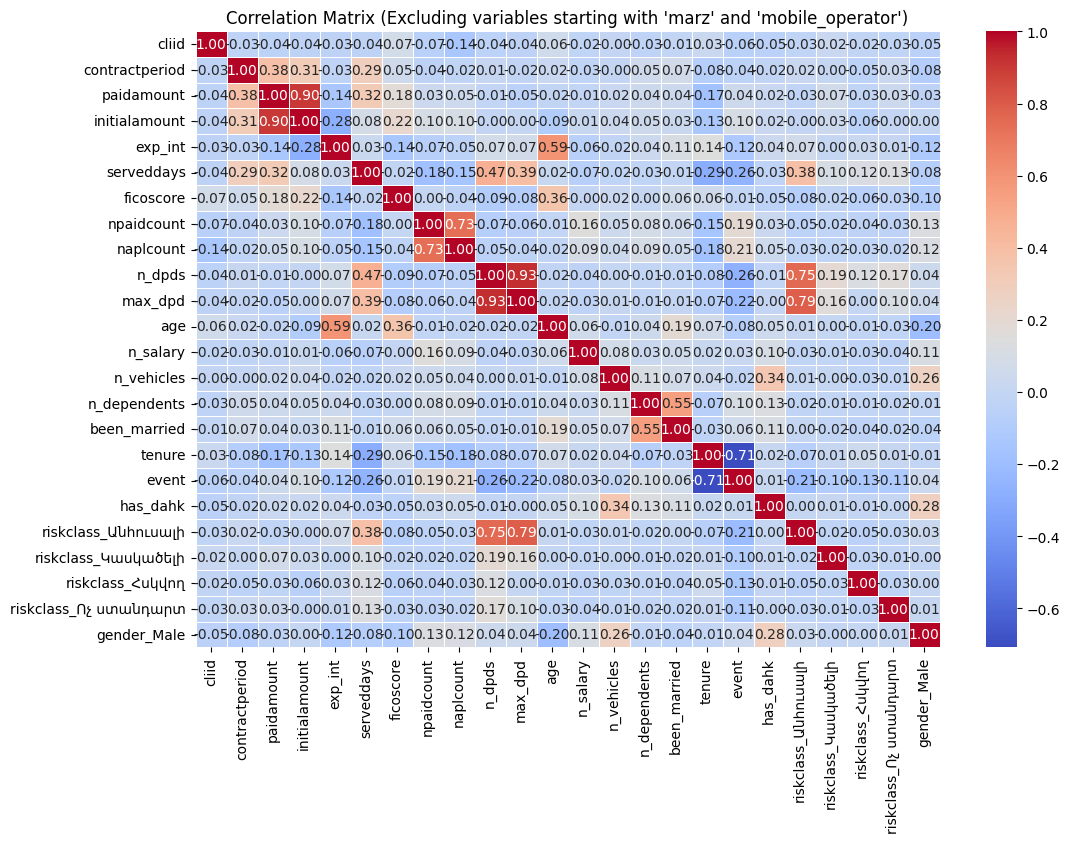

In [12]:
# Filter out columns starting with 'marz' and 'mobile_operator' for the plot to be understandable
filtered_corr_matrix = corr_matrix.loc[~(corr_matrix.index.str.startswith('marz') | corr_matrix.index.str.startswith('mobile_operator')),
                                       ~(corr_matrix.columns.str.startswith('marz') | corr_matrix.columns.str.startswith('mobile_operator'))]

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, cmap='coolwarm', linewidths=.5, fmt=".2f", annot=True)
plt.title("Correlation Matrix (Excluding variables starting with 'marz' and 'mobile_operator')")
plt.show()


### **Feature Selection:**

To avoid multicollinearity, it's advisable to remove highly correlated features. With the threshold of 0.8, in this case, we'll remove `max_dpd` and `initial_amount`.


In [13]:
surv_data = survival_df.drop(columns = ["initialamount", "max_dpd"])

# Survival Analysis

In [14]:
#Initiating our customer Survival class
inst = Survival(
    duration_col="tenure", event_col="event", primary_col="cliid", data=surv_data
)

* # Kaplan-Meier

The Kaplan-Meier estimator, often used in survival analysis, is a non-parametric univariate technique that estimates the survival function from lifetime data. It is particularly useful for analyzing time-to-event data, where the event of interest could be death, failure, or loan reactivation for our case.

The estimator calculates the probability that an event has not occurred up to a given time point. This allows for the estimation of survival curves, which depict the likelihood of survival over time.

One common approach to visualize the survival data is plotting the Kaplan-Meier survival curve. This curve illustrates the proportion of subjects surviving as a function of time, providing valuable insights into the survival experience of the population under study.

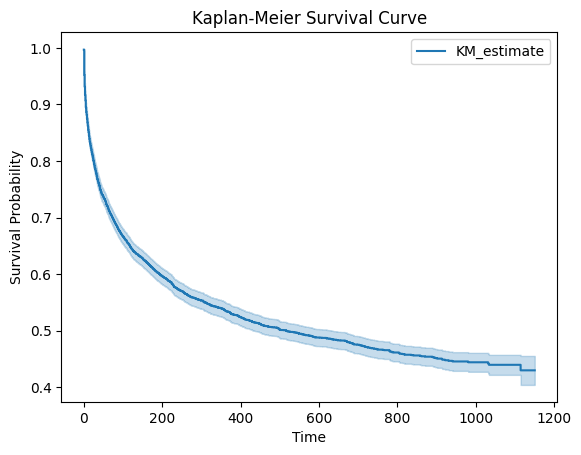

In [15]:
km = inst.fit_kaplan_meier()
inst.plot_kaplan_meier()

### **Interpretation:**

The survival curve illustrates how the survival probabilities change over the time horizon. In our case, the curve displays a promising trend - survival probabilities decreases with time.

* # Accelerated Failure Time (AFT)

Accelerated Failure Time (AFT) is one of the popular parametric models used in survival analysis.

Unlike Kaplan-Meier, this model is multivariate and allows analysis of multiple covariates and their impact on survival times. 

The model assumes that the survival function follows a parametric continuous distribution. Common distributions used in AFT models include Log-Normal, Weibull and Log-Logistic Distribution.


In [16]:
#Fitting the model with Log-Normal, Weibull, and Log-Logistic distributions and choosing the one with the lowest Akaike information criterion (AIC).
# Lower AIC values are associated with improved model fit to the data.
inst.find_best_aft_model()

#fit the model with the chosen distribution and removing insignificant variables from the model.
aft = inst.fit_best_aft_model(remove_insignificant=True) 

#printing model summary
inst.model_summary(aft)

Best distribution: Log-Normal (AIC: 31392.700205122117)


<lifelines.LogNormalAFTFitter: fitted with 4694 total observations, 2328 right-censored observations>
             duration col = 'tenure'
                event col = 'event'
   number of observations = 4694
number of events observed = 2366
           log-likelihood = -15678.446
         time fit was run = 2024-05-09 18:33:36 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                     
mu_    contractperiod               0.024     1.024     0.005           0.013           0.034               1.013               1.035
       exp_int                      0.025     1.025     0.003           0.019           0.031               1.019               1.032
       ficoscore                    0.009     1.009     0.001           0.006           0.011               1.006               1.012
       marz_ԼՈՌԻ                   -0.626     0.535     0.290          -1.194          -0.058               0.303               0.944
       marz_Չնշված                 -0.572     0.565     0.165          -0.895          -0.249               0.409               0.780
       marz_ՍՅՈՒՆԻՔ                -1.208     0.299     0.380          -1.953          -0.464               0.142               0.629
       mobile_operator_Beeline      0.386     1.471     0.170           0.052           0.719               1.053               2.053
       mobile_operator_VivacellMTS  0.246     1.278     0.141          -0.030           0.521               0.971               1.684
       n_dependents                -0.308     0.735     0.060          -0.425          -0.191               0.654               0.826
       n_dpds                       0.331     1.392     0.057           0.218           0.443               1.244               1.558
       n_vehicles                   0.275     1.316     0.080           0.118           0.432               1.125               1.540
       naplcount                   -0.063     0.939     0.007          -0.076          -0.050               0.927               0.951
       npaidcount                  -0.084     0.919     0.027          -0.137          -0.032               0.872               0.968
       paidamount                  -0.000     1.000     0.000          -0.000          -0.000               1.000               1.000
       riskclass_Անհուսալի          4.732   113.534     1.122           2.534           6.930              12.602            1022.846
       riskclass_Կասկածելի          3.280    26.564     1.069           1.183           5.376               3.266             216.068
       riskclass_Հսկվող             2.133     8.441     0.318           1.510           2.756               4.527              15.741
       riskclass_Ոչ ստանդարտ        3.952    52.049     0.883           2.221           5.683               9.217             293.916
       Intercept                   -0.065     0.937     0.820          -1.672           1.543               0.188               4.678
sigma_ Intercept                    1.158     3.184     0.016           1.127           1.189               3.086               3.284

                                    cmp to      z       p  -log2(p)
param  covariate                                                   
mu_    contractperiod                0.000  4.456 <0.0005    16.868
       exp_int                       0.000  8.134 <0.0005    51.099
       ficoscore                     0.000  6.482 <0.0005    33.366
       marz_ԼՈՌԻ                     0.000 -2.161   0.031     5.024
       marz_Չնշված                   0.000 -3.469   0.001    10.902
       marz_ՍՅՈՒՆԻՔ                  0.000 -3.180   0.001     9.406
       mobile_operator_Beeline       0.000  2.266   0.023     5.413
       mobile_operator_VivacellMTS   0.000  1.747   0.081     3.633
       n_dependents               

**Variable Interpretation:**

The AFT model coefficients can be interpreted easily: a unit increase in a covariate means the average/median survival time changes by a factor of exp(coef).

- **Contract Period:** Each additional unit of the contract period is associated with an increase in the hazard by a factor of 1.024.
- **Interest Rate (exp_int):** A one-unit increase in the interest rate is associated with an increase in the hazard by a factor of 1.025.
- **FICO Score (ficoscore):** Each one-unit increase in the FICO score is associated with an increase in the hazard by a factor of 1.009.
- **Region (marz_...):** The reference group for these variables is Yerevan. The model revealed significance for the Lori and Syuniq regions compared to Yerevan, as well as for the variable missing for the client. All three variables exhibit a decreasing effect on hazard when compared to Yerevan. Notably, the lowest p-value was obtained for the Syuniq region, indicating a decrease in the hazard by a factor of 0.299 compared to the reference region, Yerevan.
- **Mobile Operator (mobile_operator_...):** The reference group for these variables is Ucom. The model showed significance for the Beeline and VivacellMTS operators compared to the reference category. Both variables demonstrate an increasing effect on hazard in comparison with Ucom, with Beeline increasing hazard by a factor of 1.47 and VivacellMTS by a factor of 1.278.
- **Number of Dependents (n_dependents):** Each additional dependent is associated with a decrease in the hazard by a factor of 0.735.
- **Number of DPDS (n_dpds):** Each additional occurrence of a missed payment is associated with an increase in the hazard by a factor of 1.392.
- **Number of Vehicles (n_vehicles):** Each additional vehicle is associated with an increase in the hazard by a factor of 1.316.
- **Number of Paid Loans (npaidcount):** Each additional paid loan in the Company is associated with a decrease in the hazard by a factor of 0.919.
- **Paid Amount (paidamount):** Each one-unit increase in the paid amount is associated with an increase in the hazard by a rather small factor.
- **Risk Class (riskclass_...):** The reference category for these variables is the Standard risk class. Being in a risk class other than Standard significantly increases hazard.
    - "Անհուսալի" (Unreliable) increases the hazard by a factor of 113.534.
    - "Հսկվող" (Monitored) increases the hazard by a factor of 8.441.
    - "Կասկածելի" (Suspicous) increases the hazard by a factor of 26.564.
    - "Ոչ ստանդարտ" (Non-standard) increases the hazard by a factor of 52.049.

**Results Interpretation:**
The below can be used to compare different models:

- **Concordance:** The concordance value of 0.687 indicates the proportion of pairs of subjects whose predicted survival times are correctly ordered among all comparable pairs. A higher concordance value (closer to 1) suggests better predictive performance of the model regarding survival outcomes.

- **AIC (Akaike Information Criterion):** The AIC value of 31391.330 measures the model's goodness of fit, balancing the trade-off between model complexity and goodness of fit. Lower AIC values indicate better model fit relative to other models.

- **Log-Likelihood Ratio Test:** The log-likelihood ratio test with a test statistic of 1019.068 on 18 degrees of freedom (df) assesses whether the current model significantly improves the fit compared to a baseline model. In this case, a higher test statistic suggests a significant improvement in model fit.

# Exploring Feature Effects

We can use our fitted model to see how the survival changes as we change the covariate values.

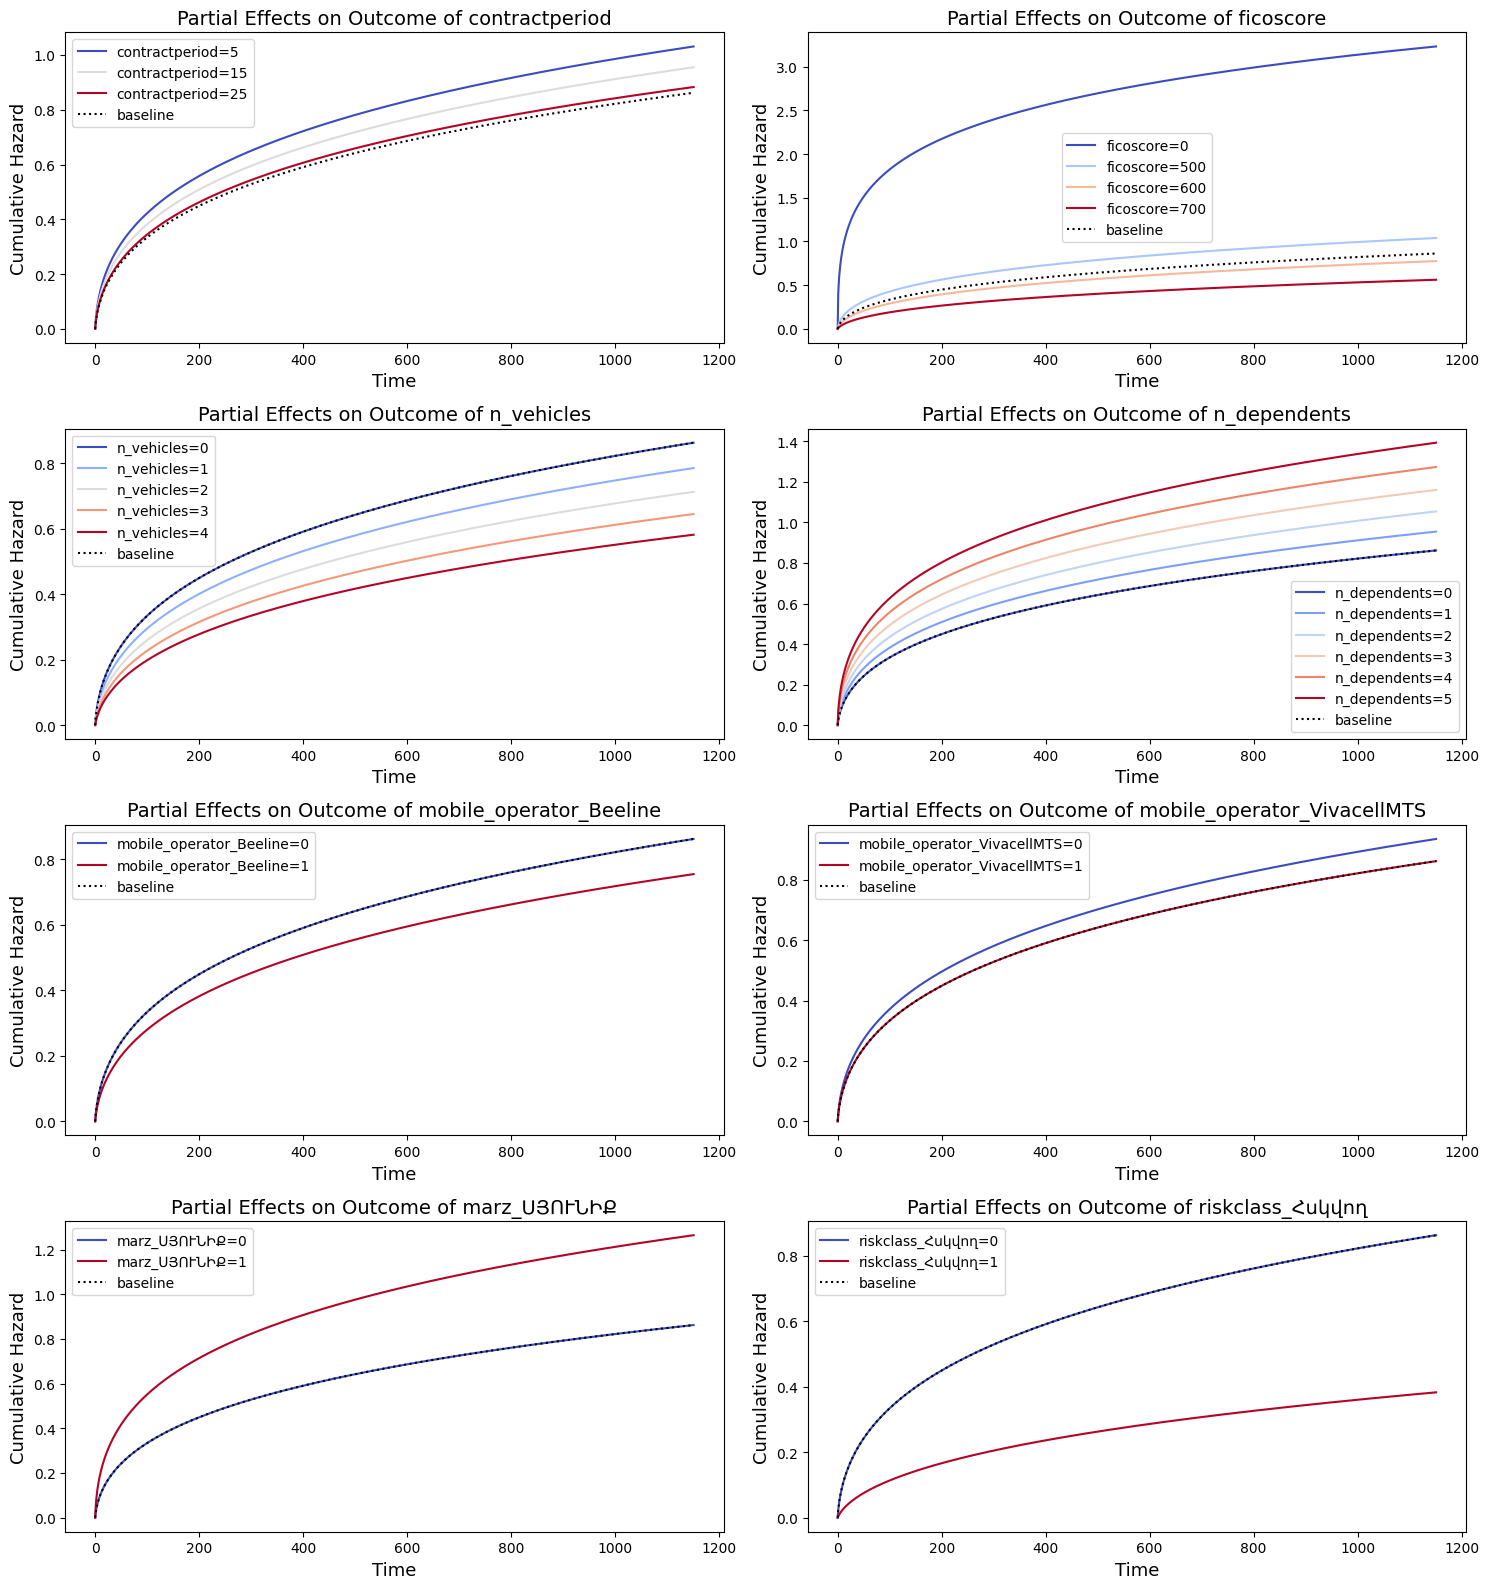

In [17]:
# Define a dictionary mapping each feature to a list of its unique values
feature_values = {
    "contractperiod": [5, 15, 25], 
    #"exp_int": [0, 20, 40, 60, 100],
    "ficoscore": [0, 500, 600, 700], 
    #"npaidcount" : [1, 3, 5, 10, 20], 
    #"n_dpds": [0, 10, 20, 30], 
    #"paidamount": [100000, 250000, 500000, 750000, 1000000],
    "n_vehicles": [0, 1, 2, 3, 4], 
    "n_dependents": [0, 1, 2, 3, 4, 5], 
    "mobile_operator_Beeline": [0, 1], 
    "mobile_operator_VivacellMTS": [0, 1],
    "marz_ՍՅՈՒՆԻՔ": [0, 1], 
    #"marz_ԼՈՌԻ": [0, 1], 
    #"marz_Չնշված": [0, 1], 
    #"riskclass_Անհուսալի": [0, 1], 
    #"riskclass_Կասկածելի": [0, 1], 
    "riskclass_Հսկվող": [0, 1], 
    #"riskclass_Ոչ ստանդարտ": [0, 1]
}

# Plot partial effects on outcome for each mapping
num_plots = len(feature_values)
num_rows = int(np.ceil(num_plots / 2))  # Adjust the number of rows as per your preference
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4 * num_rows))

for i, (feature, values) in enumerate(feature_values.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single row case
    inst.partial_effects_on_outcome(aft, feature, values, ax=ax)
    ax.set_title(f"Partial Effects on Outcome of {feature}", fontsize=14)

plt.tight_layout()
plt.show()
#plt.savefig('foo.png')

Insights on feature impacts:
* **Contract Period (contractperiod):** The shorter the contract period of the client's previous loan, the higher the likelihood of him/her returning to take another one.
* **Interest Rate (exp_int):** The lower the interest rate of the client's previous loan, the higher the likelihood of him/her returning to take another one.
* **FICO Score (ficoscore):** The lower the FICO Score, the higher the probability of him/her taking another loan. Moreover, if the client has no previous loan history (FICO Score is 0), then he/she is significantly more likely to take another loan.
* **Number of Closed Loans (nPaidCount):** The more loans the client has paid off in the Company, the higher the likelihood that the client will take another one.
* **Number of DPDS (n_dpds):** The more times the client has missed his/her payment date, the lower the likelihood that the client will take another loan.
* **Number of Vehicles (n_vehicles):** The fewer cars the client has, the higher the likelihood that the client will take another one.
* **Paid Amount (paidamount):** The more the client has paid for his latest loan, the higher the likelihood that the client will take another one.
* **Number of Dependents (n_dependents):** The more dependent the client has, the higher the likelihood of him returning to take another loan.
* **Mobile Operator:** In comparison with the Ucom mobile operator, customers of Beeline and VivacellMTS have a lower likelihood of the event occurring.
* **Region:** In comparison with Yerevan, being from the regions of Syuniq and Lori also negatively impacts the likelihood of a client returning for another loan.
* **Risk Class:** Not having a "Standard" risk class is also associated with a lower likelihood of the client returning to take another loan. 